In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import random


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

from torchvision import transforms as tf

from skimage.io import imread

from pathlib import Path
import nibabel as nib

# from tqdm import tqdm

from imgaug import augmenters as iaa

from utils.display_utils import image_grid, image_gray
from utils.neuron_dataset import Neuron_dataset
from networks.Unet_no_z_pool import Unet
from utils.trainer import train_loop

In [2]:
path = 'data/'

In [3]:
img = imread(path+'train-input.tif')
# label = imread(path+'new_labels_.tif')
label3 = imread(path+'new_labels_3x3_f.tif')
label2 = imread(path+'new_labels_2x2.tif')
(img.shape, label3.shape, label2.shape)

((100, 1024, 1024), (100, 1024, 1024), (100, 1024, 1024))

In [4]:
img =np.rollaxis(img, 0,3)
# label = np.rollaxis(label,0,3)
label2 = np.rollaxis(label2,0,3)
label3= np.rollaxis(label3,0,3)

<Figure size 432x288 with 0 Axes>

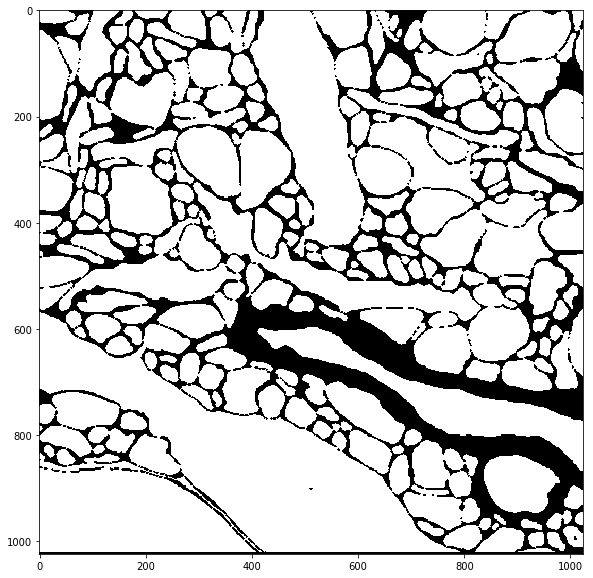

In [5]:
image_gray(label2[:,:,0])

<Figure size 432x288 with 0 Axes>

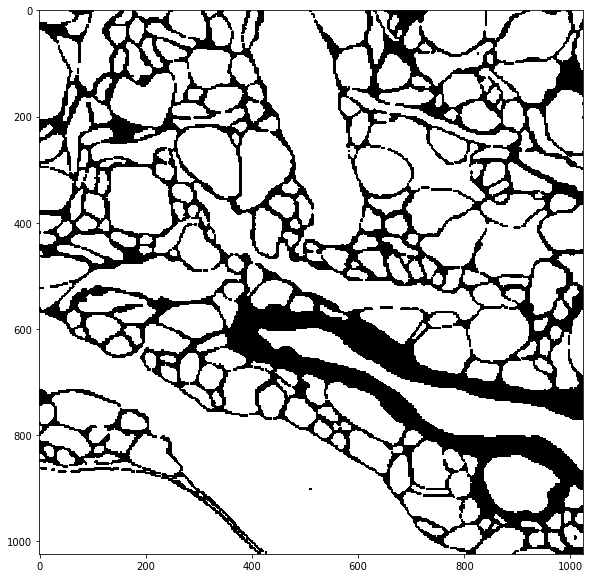

In [6]:
image_gray(label3[:,:,0])

In [7]:
image_gray(label[:,:,50])

NameError: name 'label' is not defined

In [8]:

train_l = 10000
val_l = 2000
dim_z = 6
dim_x = 64
dim_y = 64
X_train = np.zeros((train_l, dim_x, dim_y, dim_z), dtype=np.float32)
Y_train = np.zeros((train_l, dim_x, dim_y, dim_z), dtype=np.float32)

X_val = np.zeros((val_l, dim_x, dim_y, dim_z), dtype=np.float32)
Y_val = np.zeros((val_l, dim_x, dim_y, dim_z), dtype=np.float32)

#top 80
half = 32
for i in range(0,10000):
    x = np.random.randint(half,1024-half)
    y = np.random.randint(half,1024-half)
    z = np.random.randint(3,77)
    
    label_pick = np.random.randint(2)
    X_train[i] = img[x-half:x+half,y-half:y+half,z-3:z+3]
    if label_pick==0:
        Y_train[i] = label2[x-half:x+half,y-half:y+half,z-3:z+3]
    else:
        Y_train[i] = label3[x-half:x+half,y-half:y+half,z-3:z+3]

#bottom 20
for i in range(0,2000):
    x = np.random.randint(half,1024-half)
    y = np.random.randint(half,1024-half)
    z = np.random.randint(83,97)
   
    label_pick = np.random.randint(2)
    X_val[i] = img[x-half:x+half,y-half:y+half,z-3:z+3]
    if label_pick ==0:
        Y_val[i] = label2[x-half:x+half,y-half:y+half,z-3:z+3]
    else:
        Y_val[i] = label3[x-half:x+half,y-half:y+half,z-3:z+3]
    
X_train = X_train/255
X_val = X_val/255

In [9]:
neuron_dataset_train = Neuron_dataset(X_train, 
                                      train=True, 
                                      masks=Y_train,
                                      transform=True)

neuron_dataset_val = Neuron_dataset(X_val, 
                                      train=True, 
                                      masks=Y_val,
                                      transform=False)

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=neuron_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=neuron_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=True)



<Figure size 432x288 with 0 Axes>

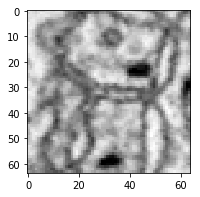

torch.Size([64, 64, 6])


In [10]:
get_image = next(iter(train_loader))
im = get_image[0][0].squeeze()
image_gray(im[:,:,4],3)
print(im.shape)

In [11]:
loop_img= get_image[0]
loop_img.shape

torch.Size([32, 1, 64, 64, 6])

In [12]:
def conv_layer(chanIn, chanOut, ks = (3,3,1), stride=1):
    return nn.Sequential(
        nn.Conv3d(chanIn, chanOut, ks, stride, padding=(1,1,0)),
        nn.ReLU(),
        nn.BatchNorm3d(chanOut)
        )

class Conv_block(nn.Module):
    def __init__(self, chanIn, chanOut, pool = False):
        super().__init__()
        
        self.conv1 = conv_layer(chanIn, chanOut)
        self.conv2 = conv_layer(chanOut, chanOut)
        
    def forward(self, x) : 
        x = self.conv1(x)
        x = self.conv2(x)
        return x
    
class Res_block(nn.Module):
    def __init__(self, chanIn, chanOut, pool=False):
        super(Res_block, self).__init__()
              
        self.conv_3x3x1 = nn.Conv3d(chanIn, chanOut,(3,3,1),1,padding=(1,1,0))
        self.bn1 = nn.BatchNorm3d(chanOut)
        self.conv_3x3x3_1 = nn.Conv3d(chanOut, chanOut,(3,3,3),1,padding=1)
        self.bn2 = nn.BatchNorm3d(chanOut)
        self.conv_3x3x3_2 = nn.Conv3d(chanOut, chanOut,(3,3,3),1,padding=1)
        self.bn3 = nn.BatchNorm3d(chanOut)
        self.activation = nn.ReLU()
        
    def forward(self, x):
#         print('shape init res: ', x.shape)
        x = self.conv_3x3x1(x)
        x = self.bn1(x)
        x = self.activation(x)
#         print('shape after 331 res: ', x.shape)
        residual = x
        
        x = self.conv_3x3x3_1(x)
        x = self.bn2(x)
        x = self.activation(x)
        
        x = self.conv_3x3x3_2(x)
        x = self.bn3(x)
        x = self.activation(x)
#         print('shape before add ', x.shape)
        x += residual
#         print('shape after add ', x.shape)
        return x

def conv_1x(chanIn, chanOut):
    return nn.Conv3d(chanIn, chanOut,(1,1,1))
        
class Mid_block(nn.Module):
    def __init__(self, chanIn, chanOut, ks=3, stride=1):
        super().__init__()        
        self.conv1 = nn.Conv3d(chanIn, chanOut, ks, padding=1)
        self.conv2 = nn.Conv3d(chanOut, chanOut, ks, padding=1)
        
    def forward(self, x) : 
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [13]:
class test_net(nn.Module):
    def __init__(self):
        super(test_net, self).__init__()
        
        self.down1 = Conv_block(1,16)
        self.down2 = Res_block(16, 16)
        self.filt_up1 = conv_1x(16,32)
        self.down3 = Res_block(32,32)
        self.filt_up2 = conv_1x(32, 64)
        self.down4 = Res_block(64,64)
        self.filt_up3 = conv_1x(64, 128)
        
        self.mid = Res_block(128,128)
        
        self.upt3 = nn.ConvTranspose3d(128,64,(2,2,1),(2,2,1))
        self.up3 =Res_block(64,64)#(256,128)
        self.upt2 = nn.ConvTranspose3d(64, 32,(2,2,1),(2,2,1))
        self.up2 = Res_block(32,32)
        self.upt1 = nn.ConvTranspose3d(32,16,(2,2,1),(2,2,1))
        self.up1 = Res_block(16,16)
        self.upt0 = nn.ConvTranspose3d(16, 16,(2,2,1),(2,2,1))
        self.up0 = Res_block(16,16)
        self.last = nn.Conv3d(16,1,1) #output channels 1 or 2
        
        self.maxPool = nn.MaxPool3d((2,2,1))
#         self.maxPool2 = nn.MaxPool3d((2,2,2))
        self.dropout = nn.Dropout3d(p=.50, inplace=True)
        
    
    def forward(self, x):
#         print('input shape', x.shape)
        #save _a for res addition
        x1_a = self.down1(x)
#         print('input shape', x1_a.shape)
        p1 = self.maxPool(x1_a)
#         print('input shape', p1.shape)
        p1 = self.dropout(p1)
#         print('p1 shape', p1.shape)
        x2_a = self.down2(p1)
#         print('after first res', x2_a.shape)
        x2 = self.filt_up1(x2_a)
#         print('up1 shape', x2.shape)
        p2 = self.maxPool(x2)
        p2 = self.dropout(p2)
        
        
        x3_a = self.down3(p2)
        x3 = self.filt_up2(x3_a)
        p3 = self.maxPool(x3)
        p3 = self.dropout(p3)
        
        x4_a = self.down4(p3)
        x4 = self.filt_up3(x4_a)
        p4 = self.maxPool(x4)
        p4 = self.dropout(p4)
#         print('looking p4', p4.shape)
        xmid = self.mid(p4)
        
        xu3 = self.upt3(xmid)
#         print('x4_a: ', x4_a.shape)
#         print('xu3 :', xu3.shape)
        add3 = torch.add(x4_a,xu3)#([x4, xu3],1) #x4,xu3
#         print('cat3', cat3.shape)
        xu3 = self.up3(add3)
        
        xu2 = self.upt2(xu3)
#         print('x3', x3.shape)
#         print('xu2', xu2.shape)
        add2 = torch.add(x3_a, xu2)
        xu2 = self.up2(add2)
        
        xu1 = self.upt1(xu2)
        add1 = torch.add(x2_a,xu1)
        xu1 = self.up1(add1)
        
        xu0 = self.upt0(xu1)
        add0 = torch.add(x1_a,xu0)
        xu0 = self.up0(add0)
        out = self.last(xu0)
#         print('output shape ',out.shape)
        return (out)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
model = test_net()
model.to(device)

test_net(
  (down1): Conv_block(
    (conv1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
      (1): ReLU()
      (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv3d(16, 16, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
      (1): ReLU()
      (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down2): Res_block(
    (conv_3x3x1): Conv3d(16, 16, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0))
    (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_3x3x3_1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_3x3x3_2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn3): BatchNorm3d(16

In [16]:
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=.1)


scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                 milestones=[100,200,400], 
                                                 gamma=0.1)
epochs = 600



EPOCH:  1
Training loss:....... 0.48549268392328254
Validation loss:..... 0.43591035642321146
NEW BEST Loss: 0.43591035642321146 ........old best:99999



/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<Figure size 432x288 with 0 Axes>

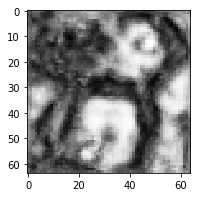

<Figure size 432x288 with 0 Axes>

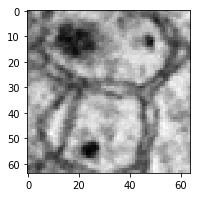


EPOCH:  2
Training loss:....... 0.413530938065471
Validation loss:..... 0.4000406000349257
NEW BEST Loss: 0.4000406000349257 ........old best:0.43591035642321146


EPOCH:  3
Training loss:....... 0.39326674974383635
Validation loss:..... 0.3820419235835
NEW BEST Loss: 0.3820419235835 ........old best:0.4000406000349257


EPOCH:  4
Training loss:....... 0.37720583288814313
Validation loss:..... 0.38044461607933044
NEW BEST Loss: 0.38044461607933044 ........old best:0.3820419235835


EPOCH:  5
Training loss:....... 0.3627406960478225
Validation loss:..... 0.36412036655441166
NEW BEST Loss: 0.36412036655441166 ........old best:0.38044461607933044


EPOCH:  6
Training loss:....... 0.3483294587546644
Validation loss:..... 0.38050519710495356

EPOCH:  7
Training loss:....... 0.33685065420290916
Validation loss:..... 0.46268762719063533

EPOCH:  8
Training loss:....... 0.3243853352702083
Validation loss:..... 0.32317044479506357
NEW BEST Loss: 0.32317044479506357 ........old best:0.364120366

<Figure size 432x288 with 0 Axes>

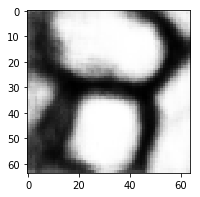

<Figure size 432x288 with 0 Axes>

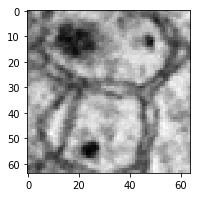


EPOCH:  22
Training loss:....... 0.2627415284752465
Validation loss:..... 0.2646961041859218

EPOCH:  23
Training loss:....... 0.26053753685646547
Validation loss:..... 0.2514208297407816
NEW BEST Loss: 0.2514208297407816 ........old best:0.2567197320953248


EPOCH:  24
Training loss:....... 0.25950631104147853
Validation loss:..... 0.2546238948901494

EPOCH:  25
Training loss:....... 0.2579928965042955
Validation loss:..... 0.2485796669645915
NEW BEST Loss: 0.2485796669645915 ........old best:0.2514208297407816


EPOCH:  26
Training loss:....... 0.2554164336036189
Validation loss:..... 0.25386579287430594

EPOCH:  27
Training loss:....... 0.25299618838313287
Validation loss:..... 0.24296883907583025
NEW BEST Loss: 0.24296883907583025 ........old best:0.2485796669645915


EPOCH:  28
Training loss:....... 0.2520354176386477
Validation loss:..... 0.26399692325364976

EPOCH:  29
Training loss:....... 0.24954590187095604
Validation loss:..... 0.24788967792003874

EPOCH:  30
Training loss:

<Figure size 432x288 with 0 Axes>

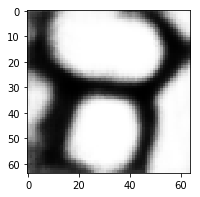

<Figure size 432x288 with 0 Axes>

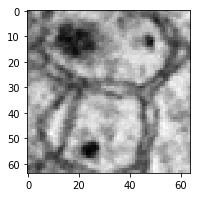


EPOCH:  42
Training loss:....... 0.23496284219213187
Validation loss:..... 0.22957992695626758

EPOCH:  43
Training loss:....... 0.23385743749217866
Validation loss:..... 0.23072801956108638

EPOCH:  44
Training loss:....... 0.2318426638651199
Validation loss:..... 0.2257425371143553
NEW BEST Loss: 0.2257425371143553 ........old best:0.22863566118573386


EPOCH:  45
Training loss:....... 0.23134411233492172
Validation loss:..... 0.22540973694551558
NEW BEST Loss: 0.22540973694551558 ........old best:0.2257425371143553


EPOCH:  46
Training loss:....... 0.23158957683049833
Validation loss:..... 0.22823456355503627

EPOCH:  47
Training loss:....... 0.23080614490059617
Validation loss:..... 0.2277723624119683

EPOCH:  48
Training loss:....... 0.22967629148937263
Validation loss:..... 0.22791988177905007

EPOCH:  49
Training loss:....... 0.2279314116928905
Validation loss:..... 0.22506382777577355
NEW BEST Loss: 0.22506382777577355 ........old best:0.22540973694551558


EPOCH:  50
Trainin

<Figure size 432x288 with 0 Axes>

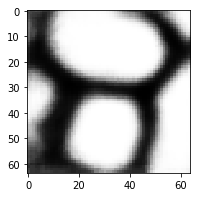

<Figure size 432x288 with 0 Axes>

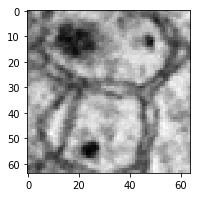


EPOCH:  62
Training loss:....... 0.2216327871663121
Validation loss:..... 0.21790873389395457
NEW BEST Loss: 0.21790873389395457 ........old best:0.2182810888403938


EPOCH:  63
Training loss:....... 0.22065474392887882
Validation loss:..... 0.21889615886741215

EPOCH:  64
Training loss:....... 0.2195951842461912
Validation loss:..... 0.21792206049911558

EPOCH:  65
Training loss:....... 0.22044484317302704
Validation loss:..... 0.21648020829473222
NEW BEST Loss: 0.21648020829473222 ........old best:0.21790873389395457


EPOCH:  66
Training loss:....... 0.21958287226887177
Validation loss:..... 0.2199729359339154

EPOCH:  67
Training loss:....... 0.2198002245098638
Validation loss:..... 0.21614248908701397
NEW BEST Loss: 0.21614248908701397 ........old best:0.21648020829473222


EPOCH:  68
Training loss:....... 0.219147652911302
Validation loss:..... 0.21425723934930468
NEW BEST Loss: 0.21425723934930468 ........old best:0.21614248908701397


EPOCH:  69
Training loss:....... 0.2190041

<Figure size 432x288 with 0 Axes>

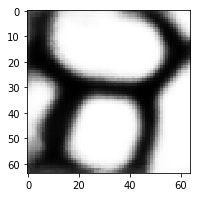

<Figure size 432x288 with 0 Axes>

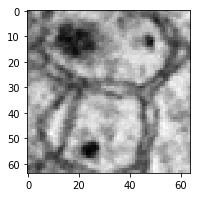


EPOCH:  82
Training loss:....... 0.21486380653449902
Validation loss:..... 0.21083318382974656

EPOCH:  83
Training loss:....... 0.21354263044965152
Validation loss:..... 0.2117911676565806

EPOCH:  84
Training loss:....... 0.2135668301258605
Validation loss:..... 0.21741761929459041

EPOCH:  85
Training loss:....... 0.2127536813291117
Validation loss:..... 0.21338662103055014

EPOCH:  86
Training loss:....... 0.21404335497857663
Validation loss:..... 0.2115180270066337

EPOCH:  87
Training loss:....... 0.21244463967248656
Validation loss:..... 0.20916844431370024
NEW BEST Loss: 0.20916844431370024 ........old best:0.20919521696983823


EPOCH:  88
Training loss:....... 0.21187242194296071
Validation loss:..... 0.20939779612753126

EPOCH:  89
Training loss:....... 0.214161912568461
Validation loss:..... 0.21292061938179863

EPOCH:  90
Training loss:....... 0.2115422363003222
Validation loss:..... 0.21203737339330098

EPOCH:  91
Training loss:....... 0.21364038082928702
Validation loss:

<Figure size 432x288 with 0 Axes>

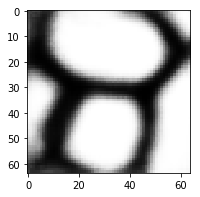

<Figure size 432x288 with 0 Axes>

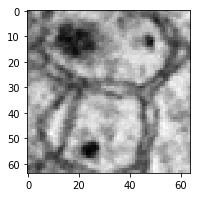


EPOCH:  102
Training loss:....... 0.2059778534947112
Validation loss:..... 0.2048761404695965
NEW BEST Loss: 0.2048761404695965 ........old best:0.20533765876103963


EPOCH:  103
Training loss:....... 0.20591261206914824
Validation loss:..... 0.2052347395155165

EPOCH:  104
Training loss:....... 0.20607296784464924
Validation loss:..... 0.2052722523609797

EPOCH:  105
Training loss:....... 0.20557944738445952
Validation loss:..... 0.2041650695933236
NEW BEST Loss: 0.2041650695933236 ........old best:0.2048761404695965


EPOCH:  106
Training loss:....... 0.20546042000333342
Validation loss:..... 0.20441002339597733

EPOCH:  107
Training loss:....... 0.20506519450547214
Validation loss:..... 0.20320549701887464
NEW BEST Loss: 0.20320549701887464 ........old best:0.2041650695933236


EPOCH:  108
Training loss:....... 0.2048227574688177
Validation loss:..... 0.20486338696782552

EPOCH:  109
Training loss:....... 0.2048478632594069
Validation loss:..... 0.20429981298862943

EPOCH:  110
Tra

<Figure size 432x288 with 0 Axes>

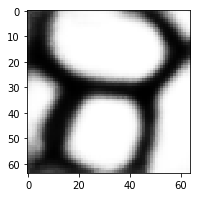

<Figure size 432x288 with 0 Axes>

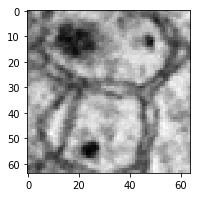


EPOCH:  122
Training loss:....... 0.20430157850154293
Validation loss:..... 0.20331774391825236

EPOCH:  123
Training loss:....... 0.20404021727581756
Validation loss:..... 0.20294859910768176

EPOCH:  124
Training loss:....... 0.2041486844944116
Validation loss:..... 0.2039010990706701

EPOCH:  125
Training loss:....... 0.20438754891816038
Validation loss:..... 0.2047320126541077

EPOCH:  126
Training loss:....... 0.20454276031769883
Validation loss:..... 0.20390299601214273

EPOCH:  127
Training loss:....... 0.20410838889809083
Validation loss:..... 0.2034980510435407

EPOCH:  128
Training loss:....... 0.20428219808938022
Validation loss:..... 0.20545360114839342

EPOCH:  129
Training loss:....... 0.20410557067432342
Validation loss:..... 0.20318672510366592

EPOCH:  130
Training loss:....... 0.20389056343811388
Validation loss:..... 0.20367405007755945

EPOCH:  131
Training loss:....... 0.20426607198608568
Validation loss:..... 0.20369020175366176

EPOCH:  132
Training loss:.......

<Figure size 432x288 with 0 Axes>

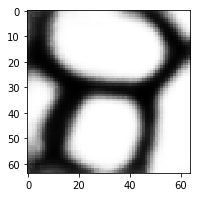

<Figure size 432x288 with 0 Axes>

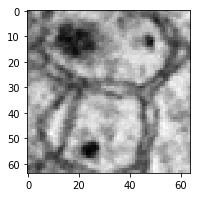


EPOCH:  142
Training loss:....... 0.20348570179253722
Validation loss:..... 0.20352891986332242

EPOCH:  143
Training loss:....... 0.20390170988754724
Validation loss:..... 0.2039518595214874

EPOCH:  144
Training loss:....... 0.20335928695841718
Validation loss:..... 0.20445133982196687

EPOCH:  145
Training loss:....... 0.20375478124847046
Validation loss:..... 0.20294799241754743

EPOCH:  146
Training loss:....... 0.20366691586118155
Validation loss:..... 0.20340950550541045

EPOCH:  147
Training loss:....... 0.2036673062430403
Validation loss:..... 0.20334413150946298

EPOCH:  148
Training loss:....... 0.2030732584075806
Validation loss:..... 0.20485775716721066

EPOCH:  149
Training loss:....... 0.20352843513313573
Validation loss:..... 0.20343128343423209

EPOCH:  150
Training loss:....... 0.20342604225626387
Validation loss:..... 0.20209689840437875

EPOCH:  151
Training loss:....... 0.20326270186863007
Validation loss:..... 0.2029631348356368

EPOCH:  152
Training loss:.......

<Figure size 432x288 with 0 Axes>

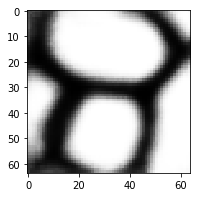

<Figure size 432x288 with 0 Axes>

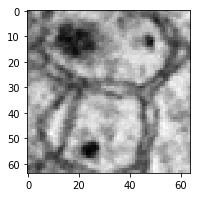


EPOCH:  162
Training loss:....... 0.2030512629130397
Validation loss:..... 0.20267799922398158

EPOCH:  163
Training loss:....... 0.20302984580254782
Validation loss:..... 0.20338050548046355

EPOCH:  164
Training loss:....... 0.20307519075017386
Validation loss:..... 0.20285763887185898

EPOCH:  165
Training loss:....... 0.2025714385718964
Validation loss:..... 0.20298837574701462

EPOCH:  166
Training loss:....... 0.20279390681475495
Validation loss:..... 0.20558993849489424

EPOCH:  167
Training loss:....... 0.2030065435761461
Validation loss:..... 0.20374356257537055

EPOCH:  168
Training loss:....... 0.20289933533904653
Validation loss:..... 0.20354921595444755

EPOCH:  169
Training loss:....... 0.2026636634295741
Validation loss:..... 0.20306796876211014

EPOCH:  170
Training loss:....... 0.20310842809966578
Validation loss:..... 0.20268431093011582

EPOCH:  171
Training loss:....... 0.2029032234471446
Validation loss:..... 0.2024628072977066

EPOCH:  172
Training loss:....... 0

<Figure size 432x288 with 0 Axes>

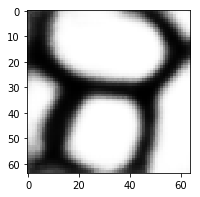

<Figure size 432x288 with 0 Axes>

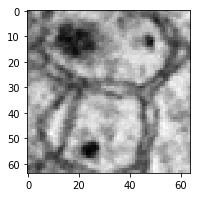


EPOCH:  182
Training loss:....... 0.20283254938194165
Validation loss:..... 0.20159209720672122

EPOCH:  183
Training loss:....... 0.2026600716308283
Validation loss:..... 0.202460473492032

EPOCH:  184
Training loss:....... 0.20258127890836697
Validation loss:..... 0.20171961046400524

EPOCH:  185
Training loss:....... 0.2029855373187568
Validation loss:..... 0.20184613906201862

EPOCH:  186
Training loss:....... 0.2022498697994616
Validation loss:..... 0.20365326603253683

EPOCH:  187
Training loss:....... 0.20249491082593657
Validation loss:..... 0.2063350984974513

EPOCH:  188
Training loss:....... 0.20250121054177087
Validation loss:..... 0.20347242861513107

EPOCH:  189
Training loss:....... 0.20205280360893701
Validation loss:..... 0.2022646081352991

EPOCH:  190
Training loss:....... 0.20220269691258574
Validation loss:..... 0.2033173366198464

EPOCH:  191
Training loss:....... 0.20204295008517684
Validation loss:..... 0.20194193436985924

EPOCH:  192
Training loss:....... 0.2

<Figure size 432x288 with 0 Axes>

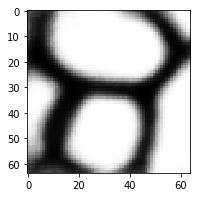

<Figure size 432x288 with 0 Axes>

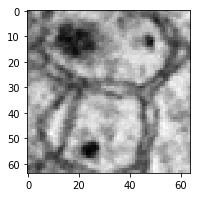


EPOCH:  202
Training loss:....... 0.20200907365201762
Validation loss:..... 0.2017069962762651

EPOCH:  203
Training loss:....... 0.20151782383362707
Validation loss:..... 0.2008477442321323
NEW BEST Loss: 0.2008477442321323 ........old best:0.20111013333948832


EPOCH:  204
Training loss:....... 0.20153370556739952
Validation loss:..... 0.2019257606968047

EPOCH:  205
Training loss:....... 0.20175317077400584
Validation loss:..... 0.20176500507763453

EPOCH:  206
Training loss:....... 0.2018379469077808
Validation loss:..... 0.20177218223374987

EPOCH:  207
Training loss:....... 0.20193693813043662
Validation loss:..... 0.20268351596499246

EPOCH:  208
Training loss:....... 0.20211214517442563
Validation loss:..... 0.20105797572741432

EPOCH:  209
Training loss:....... 0.20146998996361376
Validation loss:..... 0.20220567002182915

EPOCH:  210
Training loss:....... 0.20162257566429176
Validation loss:..... 0.2011076214294585

EPOCH:  211
Training loss:....... 0.20144512463872805
Valid

<Figure size 432x288 with 0 Axes>

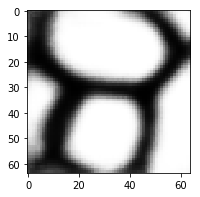

<Figure size 432x288 with 0 Axes>

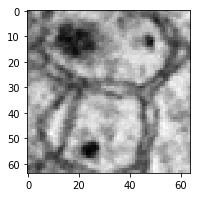


EPOCH:  222
Training loss:....... 0.20205556041897296
Validation loss:..... 0.20210291610823738

EPOCH:  223
Training loss:....... 0.20170681102397725
Validation loss:..... 0.20166223460719698

EPOCH:  224
Training loss:....... 0.2012503304706214
Validation loss:..... 0.20166405846202184

EPOCH:  225
Training loss:....... 0.2014097632310642
Validation loss:..... 0.201492253986616

EPOCH:  226
Training loss:....... 0.20189167283023127
Validation loss:..... 0.2012198737689427

EPOCH:  227
Training loss:....... 0.2015094091050541
Validation loss:..... 0.20272524938696906

EPOCH:  228
Training loss:....... 0.2017470443496308
Validation loss:..... 0.20290046906660472

EPOCH:  229
Training loss:....... 0.20188628022853558
Validation loss:..... 0.20204475640304506

EPOCH:  230
Training loss:....... 0.20185200993816693
Validation loss:..... 0.2024609777662489

EPOCH:  231
Training loss:....... 0.20155002752812906
Validation loss:..... 0.2032298483545818

EPOCH:  232
Training loss:....... 0.20

<Figure size 432x288 with 0 Axes>

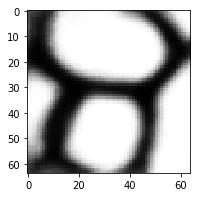

<Figure size 432x288 with 0 Axes>

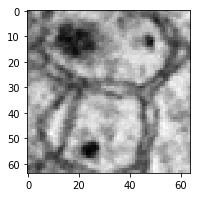


EPOCH:  242
Training loss:....... 0.20141593007424388
Validation loss:..... 0.20202694762320744

EPOCH:  243
Training loss:....... 0.20147999583151394
Validation loss:..... 0.20137398701811593

EPOCH:  244
Training loss:....... 0.20166320337083773
Validation loss:..... 0.20103352859852805

EPOCH:  245
Training loss:....... 0.20137290366160604
Validation loss:..... 0.201892131850833

EPOCH:  246
Training loss:....... 0.20178036672619584
Validation loss:..... 0.2024225557134265

EPOCH:  247
Training loss:....... 0.20191609692840148
Validation loss:..... 0.20101077996549152

EPOCH:  248
Training loss:....... 0.20125471307827641
Validation loss:..... 0.20211837854650286

EPOCH:  249
Training loss:....... 0.20134269500883242
Validation loss:..... 0.20153662798896668

EPOCH:  250
Training loss:....... 0.20160603118590273
Validation loss:..... 0.20283486303829013

EPOCH:  251
Training loss:....... 0.20140534367995522
Validation loss:..... 0.2038006396993758

EPOCH:  252
Training loss:.......

<Figure size 432x288 with 0 Axes>

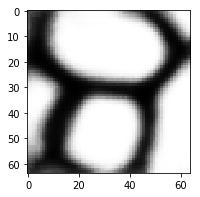

<Figure size 432x288 with 0 Axes>

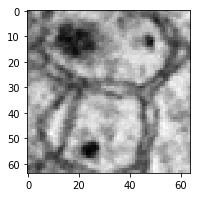


EPOCH:  262
Training loss:....... 0.2012043174463339
Validation loss:..... 0.20190127193927765

EPOCH:  263
Training loss:....... 0.20119513028536362
Validation loss:..... 0.20164485535924398

EPOCH:  264
Training loss:....... 0.201419365006133
Validation loss:..... 0.20186240923783136

EPOCH:  265
Training loss:....... 0.20130551080353343
Validation loss:..... 0.2028065841822397

EPOCH:  266
Training loss:....... 0.2014725016900145
Validation loss:..... 0.20306666313655794

EPOCH:  267
Training loss:....... 0.20109765983808536
Validation loss:..... 0.20211721554635062

EPOCH:  268
Training loss:....... 0.2017233223675158
Validation loss:..... 0.2020621562287921

EPOCH:  269
Training loss:....... 0.20130571313559437
Validation loss:..... 0.2025840478757071

EPOCH:  270
Training loss:....... 0.20194633409809382
Validation loss:..... 0.2022627540050991

EPOCH:  271
Training loss:....... 0.20136092050959126
Validation loss:..... 0.20142586718476008

EPOCH:  272
Training loss:....... 0.20

<Figure size 432x288 with 0 Axes>

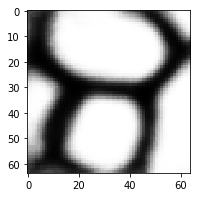

<Figure size 432x288 with 0 Axes>

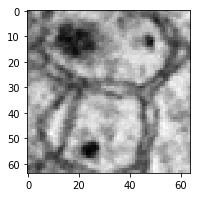


EPOCH:  282
Training loss:....... 0.20144771334652703
Validation loss:..... 0.20445009214537485

EPOCH:  283
Training loss:....... 0.20175113098118633
Validation loss:..... 0.2023848517546578

EPOCH:  284
Training loss:....... 0.20152396706346506
Validation loss:..... 0.20250121444936783

EPOCH:  285
Training loss:....... 0.20157277131804263
Validation loss:..... 0.20293108764148893

EPOCH:  286
Training loss:....... 0.2014204703580838
Validation loss:..... 0.2018565476413757

EPOCH:  287
Training loss:....... 0.2016253727503097
Validation loss:..... 0.20196728668515646

EPOCH:  288
Training loss:....... 0.20169646019181506
Validation loss:..... 0.20298329397799478

EPOCH:  289
Training loss:....... 0.2014051079750061
Validation loss:..... 0.2034101476745

EPOCH:  290
Training loss:....... 0.20162001266456642
Validation loss:..... 0.20261030916183714

EPOCH:  291
Training loss:....... 0.2014979294028145
Validation loss:..... 0.20161461144212692

EPOCH:  292
Training loss:....... 0.201

<Figure size 432x288 with 0 Axes>

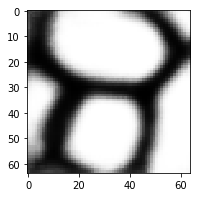

<Figure size 432x288 with 0 Axes>

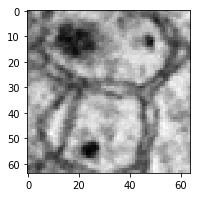


EPOCH:  302
Training loss:....... 0.20123959363649446
Validation loss:..... 0.20179435397897447

EPOCH:  303
Training loss:....... 0.2014342341274499
Validation loss:..... 0.2014541287743856

EPOCH:  304
Training loss:....... 0.20147486930838027
Validation loss:..... 0.20242716797760554

EPOCH:  305
Training loss:....... 0.20145896153328136
Validation loss:..... 0.20196989084046985

EPOCH:  306
Training loss:....... 0.20125909744741055
Validation loss:..... 0.20181451359438518

EPOCH:  307
Training loss:....... 0.20132751624805098
Validation loss:..... 0.20334604122335947

EPOCH:  308
Training loss:....... 0.2012272551893807
Validation loss:..... 0.20221950350299714

EPOCH:  309
Training loss:....... 0.20105483480535757
Validation loss:..... 0.20240519798937298

EPOCH:  310
Training loss:....... 0.20135479708449147
Validation loss:..... 0.2025332748889923

EPOCH:  311
Training loss:....... 0.20116214839795146
Validation loss:..... 0.2018745125286163

EPOCH:  312
Training loss:....... 

<Figure size 432x288 with 0 Axes>

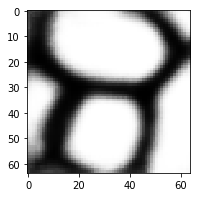

<Figure size 432x288 with 0 Axes>

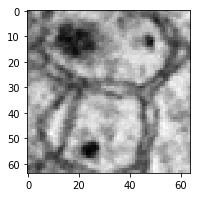


EPOCH:  322
Training loss:....... 0.20140770372872155
Validation loss:..... 0.20306036443937392

EPOCH:  323
Training loss:....... 0.20105241072444488
Validation loss:..... 0.20266141115673006

EPOCH:  324
Training loss:....... 0.20139678422444926
Validation loss:..... 0.2022551702601569

EPOCH:  325
Training loss:....... 0.20124554281798415
Validation loss:..... 0.20136326338563645

EPOCH:  326
Training loss:....... 0.20164294664661725
Validation loss:..... 0.20257963334757184

EPOCH:  327
Training loss:....... 0.2012860663592244
Validation loss:..... 0.20152504742145538

EPOCH:  328
Training loss:....... 0.20152496634580838
Validation loss:..... 0.2011841367634516

EPOCH:  329
Training loss:....... 0.20128888620164828
Validation loss:..... 0.20158624081384569

EPOCH:  330
Training loss:....... 0.2013958431185244
Validation loss:..... 0.20198043826080503

EPOCH:  331
Training loss:....... 0.20137857924254177
Validation loss:..... 0.20209950610758767

EPOCH:  332
Training loss:.......

<Figure size 432x288 with 0 Axes>

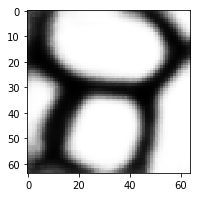

<Figure size 432x288 with 0 Axes>

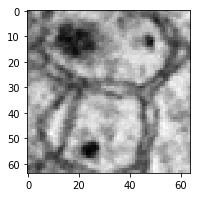


EPOCH:  342
Training loss:....... 0.20151928895578597
Validation loss:..... 0.20229698220888773

EPOCH:  343
Training loss:....... 0.2011105800969913
Validation loss:..... 0.20188756168834746

EPOCH:  344
Training loss:....... 0.20126746804379045
Validation loss:..... 0.20289425812070333

EPOCH:  345
Training loss:....... 0.20116722283843227
Validation loss:..... 0.20323179756838178

EPOCH:  346
Training loss:....... 0.20111525015899548
Validation loss:..... 0.20230214794476828

EPOCH:  347
Training loss:....... 0.20103850641760962
Validation loss:..... 0.2026198451954221

EPOCH:  348
Training loss:....... 0.20150909627588412
Validation loss:..... 0.20223096746300895

EPOCH:  349
Training loss:....... 0.20104123747196442
Validation loss:..... 0.20210469951705326

EPOCH:  350
Training loss:....... 0.20120687597095013
Validation loss:..... 0.20253682349409377

EPOCH:  351
Training loss:....... 0.20129458234904293
Validation loss:..... 0.20214175492052047

EPOCH:  352
Training loss:.....

<Figure size 432x288 with 0 Axes>

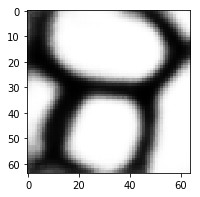

<Figure size 432x288 with 0 Axes>

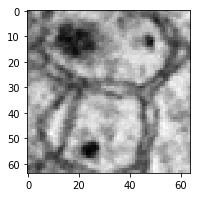


EPOCH:  362
Training loss:....... 0.20120571753658806
Validation loss:..... 0.20269601827576048

EPOCH:  363
Training loss:....... 0.20128914299673928
Validation loss:..... 0.20166397946221487

EPOCH:  364
Training loss:....... 0.2011346520421604
Validation loss:..... 0.20214484868541596

EPOCH:  365
Training loss:....... 0.20102585118989974
Validation loss:..... 0.20155941186443208

EPOCH:  366
Training loss:....... 0.2015828928722741
Validation loss:..... 0.20158742249958098

EPOCH:  367
Training loss:....... 0.2010923150343636
Validation loss:..... 0.20080872329454574
NEW BEST Loss: 0.20080872329454574 ........old best:0.20081601516594963


EPOCH:  368
Training loss:....... 0.2008695717627248
Validation loss:..... 0.2016433822730231

EPOCH:  369
Training loss:....... 0.2015877560780833
Validation loss:..... 0.20260684641580734

EPOCH:  370
Training loss:....... 0.20105753148706576
Validation loss:..... 0.2016517167526578

EPOCH:  371
Training loss:....... 0.2009458061986076
Validat

<Figure size 432x288 with 0 Axes>

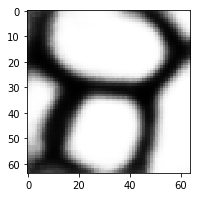

<Figure size 432x288 with 0 Axes>

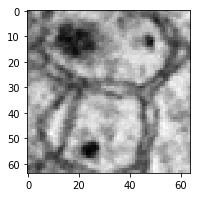


EPOCH:  382
Training loss:....... 0.20143621560102834
Validation loss:..... 0.2028289988400444

EPOCH:  383
Training loss:....... 0.201142256775984
Validation loss:..... 0.2017422335015403

EPOCH:  384
Training loss:....... 0.2007166719950807
Validation loss:..... 0.2009830836738859

EPOCH:  385
Training loss:....... 0.2013704201188712
Validation loss:..... 0.20168895097005934

EPOCH:  386
Training loss:....... 0.20115377327885492
Validation loss:..... 0.20080835715172782
NEW BEST Loss: 0.20080835715172782 ........old best:0.20080872329454574


EPOCH:  387
Training loss:....... 0.2013106819349356
Validation loss:..... 0.20254461467266083

EPOCH:  388
Training loss:....... 0.20137515673622156
Validation loss:..... 0.20287649759224483

EPOCH:  389
Training loss:....... 0.20153101202778922
Validation loss:..... 0.20274810398381854

EPOCH:  390
Training loss:....... 0.2011021455160726
Validation loss:..... 0.20231480257851736

EPOCH:  391
Training loss:....... 0.20133951620552867
Validati

<Figure size 432x288 with 0 Axes>

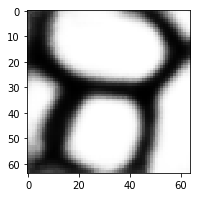

<Figure size 432x288 with 0 Axes>

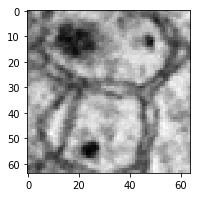


EPOCH:  402
Training loss:....... 0.20139635275728024
Validation loss:..... 0.20282283685510122

EPOCH:  403
Training loss:....... 0.2011606591863754
Validation loss:..... 0.20233240179599277

EPOCH:  404
Training loss:....... 0.2011914746925092
Validation loss:..... 0.2011082378171739

EPOCH:  405
Training loss:....... 0.20115537651049825
Validation loss:..... 0.20266938304144239

EPOCH:  406
Training loss:....... 0.20093363442550452
Validation loss:..... 0.2030605784957371

EPOCH:  407
Training loss:....... 0.20093943250065033
Validation loss:..... 0.20241941133188823

EPOCH:  408
Training loss:....... 0.2011124196524818
Validation loss:..... 0.20216371237285555

EPOCH:  409
Training loss:....... 0.20113805507699523
Validation loss:..... 0.2013402067952686

EPOCH:  410
Training loss:....... 0.2010400165288974
Validation loss:..... 0.20137739607266017

EPOCH:  411
Training loss:....... 0.20138854483445992
Validation loss:..... 0.20132602656644488

EPOCH:  412
Training loss:....... 0.

<Figure size 432x288 with 0 Axes>

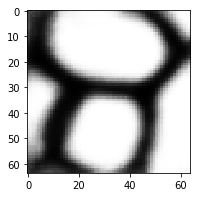

<Figure size 432x288 with 0 Axes>

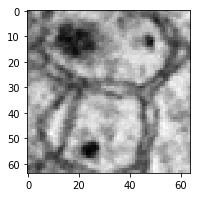


EPOCH:  422
Training loss:....... 0.20104872832854334
Validation loss:..... 0.20138744820678045

EPOCH:  423
Training loss:....... 0.20117049142956353
Validation loss:..... 0.20188551336999924

EPOCH:  424
Training loss:....... 0.20105673187076092
Validation loss:..... 0.20235740523489695

EPOCH:  425
Training loss:....... 0.201543454925854
Validation loss:..... 0.20213090995001415

EPOCH:  426
Training loss:....... 0.20134226920696113
Validation loss:..... 0.20352492635212246

EPOCH:  427
Training loss:....... 0.201497400530611
Validation loss:..... 0.20186165188040053

EPOCH:  428
Training loss:....... 0.20106675021183756
Validation loss:..... 0.2017639738226694

EPOCH:  429
Training loss:....... 0.20149171023894422
Validation loss:..... 0.20192136698298985

EPOCH:  430
Training loss:....... 0.20119657469824098
Validation loss:..... 0.202114541852285

EPOCH:  431
Training loss:....... 0.20111187825949428
Validation loss:..... 0.20131010337481423

EPOCH:  432
Training loss:....... 0.

<Figure size 432x288 with 0 Axes>

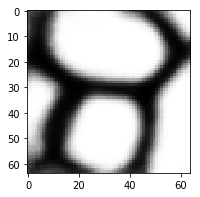

<Figure size 432x288 with 0 Axes>

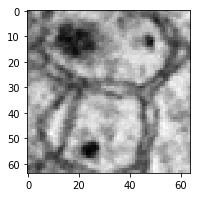


EPOCH:  442
Training loss:....... 0.20125881737223067
Validation loss:..... 0.20162654017645215

EPOCH:  443
Training loss:....... 0.20075160583939416
Validation loss:..... 0.20111956411883944

EPOCH:  444
Training loss:....... 0.20100660050829378
Validation loss:..... 0.20240022407637703

EPOCH:  445
Training loss:....... 0.20117527317886535
Validation loss:..... 0.2028963270168456

EPOCH:  446
Training loss:....... 0.20076540693307457
Validation loss:..... 0.20326398313045502

EPOCH:  447
Training loss:....... 0.20139809395558536
Validation loss:..... 0.20248534731448642

EPOCH:  448
Training loss:....... 0.20156117293019646
Validation loss:..... 0.20141900555481987

EPOCH:  449
Training loss:....... 0.2011370954041283
Validation loss:..... 0.20189286886699617

EPOCH:  450
Training loss:....... 0.2013316489161013
Validation loss:..... 0.2017818291982015

EPOCH:  451
Training loss:....... 0.20101537448339188
Validation loss:..... 0.20143714121409825

EPOCH:  452
Training loss:.......

<Figure size 432x288 with 0 Axes>

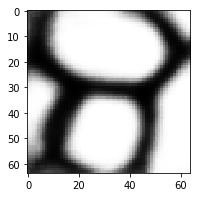

<Figure size 432x288 with 0 Axes>

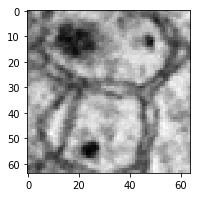


EPOCH:  462
Training loss:....... 0.2007365881349332
Validation loss:..... 0.20272155957562582

EPOCH:  463
Training loss:....... 0.2011913345359004
Validation loss:..... 0.2028260555059191

EPOCH:  464
Training loss:....... 0.20082631835731835
Validation loss:..... 0.201561937966044

EPOCH:  465
Training loss:....... 0.20097369136520848
Validation loss:..... 0.20151382826623462

EPOCH:  466
Training loss:....... 0.2007486800225779
Validation loss:..... 0.20116128949891954

EPOCH:  467
Training loss:....... 0.20124256382354153
Validation loss:..... 0.20175586640834808

EPOCH:  468
Training loss:....... 0.20075781372027657
Validation loss:..... 0.20111719743599968

EPOCH:  469
Training loss:....... 0.20125994348107054
Validation loss:..... 0.2014662909602362

EPOCH:  470
Training loss:....... 0.20132101072480504
Validation loss:..... 0.20131203816050575

EPOCH:  471
Training loss:....... 0.20120762821774893
Validation loss:..... 0.20276570414739942

EPOCH:  472
Training loss:....... 0.

<Figure size 432x288 with 0 Axes>

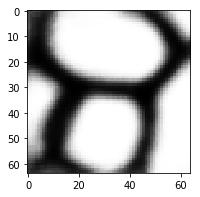

<Figure size 432x288 with 0 Axes>

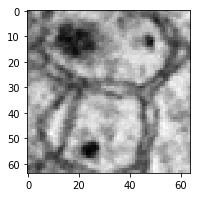


EPOCH:  482
Training loss:....... 0.20092184808307562
Validation loss:..... 0.20276999308003318

EPOCH:  483
Training loss:....... 0.2009799719428102
Validation loss:..... 0.20180042111684407

EPOCH:  484
Training loss:....... 0.20068983290903866
Validation loss:..... 0.20212685730722216

EPOCH:  485
Training loss:....... 0.20105493097259594
Validation loss:..... 0.20207549607942973

EPOCH:  486
Training loss:....... 0.2010696285639327
Validation loss:..... 0.20133546089369153

EPOCH:  487
Training loss:....... 0.2012496768190457
Validation loss:..... 0.20278485616048178

EPOCH:  488
Training loss:....... 0.20121119578425495
Validation loss:..... 0.20116849054419805

EPOCH:  489
Training loss:....... 0.20106930464220504
Validation loss:..... 0.20094341205226052

EPOCH:  490
Training loss:....... 0.20084744725174036
Validation loss:..... 0.2024493030612431

EPOCH:  491
Training loss:....... 0.2012792842361493
Validation loss:..... 0.2032844199547692

EPOCH:  492
Training loss:....... 0

<Figure size 432x288 with 0 Axes>

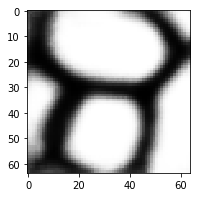

<Figure size 432x288 with 0 Axes>

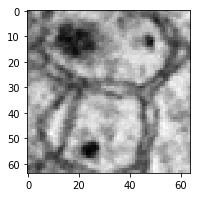


EPOCH:  502
Training loss:....... 0.20110111847853127
Validation loss:..... 0.20076051378060902

EPOCH:  503
Training loss:....... 0.20123824500999513
Validation loss:..... 0.2014270488704954

EPOCH:  504
Training loss:....... 0.20108335134320365
Validation loss:..... 0.20134602084992423

EPOCH:  505
Training loss:....... 0.20104796775042438
Validation loss:..... 0.20202253262201944

EPOCH:  506
Training loss:....... 0.2015515179298937
Validation loss:..... 0.2020891611538236

EPOCH:  507
Training loss:....... 0.20106794182865764
Validation loss:..... 0.2015130463100615

EPOCH:  508
Training loss:....... 0.2011018507301617
Validation loss:..... 0.2027688312625128

EPOCH:  509
Training loss:....... 0.20103466148955373
Validation loss:..... 0.2017802418697448

EPOCH:  510
Training loss:....... 0.20074411793448294
Validation loss:..... 0.20165580723966872

EPOCH:  511
Training loss:....... 0.2013633001250581
Validation loss:..... 0.20337461218947456

EPOCH:  512
Training loss:....... 0.2

<Figure size 432x288 with 0 Axes>

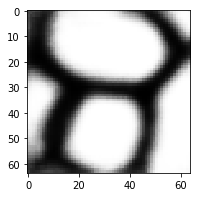

<Figure size 432x288 with 0 Axes>

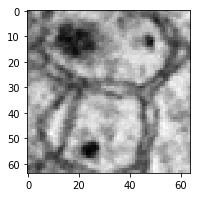


EPOCH:  522
Training loss:....... 0.20111204669498406
Validation loss:..... 0.20497038321835653

EPOCH:  523
Training loss:....... 0.20107853660187403
Validation loss:..... 0.2015400119717159

EPOCH:  524
Training loss:....... 0.2007719855815077
Validation loss:..... 0.20271196866792346

EPOCH:  525
Training loss:....... 0.20157757544289
Validation loss:..... 0.20249111027944655

EPOCH:  526
Training loss:....... 0.20098637510983708
Validation loss:..... 0.20202717516157362

EPOCH:  527
Training loss:....... 0.20103627048170986
Validation loss:..... 0.2012870955088782

EPOCH:  528
Training loss:....... 0.20121207676185204
Validation loss:..... 0.2020011189438048

EPOCH:  529
Training loss:....... 0.2005426462846823
Validation loss:..... 0.20352642687540207

EPOCH:  530
Training loss:....... 0.20107968518147454
Validation loss:..... 0.20156612755760314

EPOCH:  531
Training loss:....... 0.20098203539657897
Validation loss:..... 0.20139683617485893

EPOCH:  532
Training loss:....... 0.2

<Figure size 432x288 with 0 Axes>

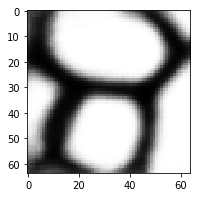

<Figure size 432x288 with 0 Axes>

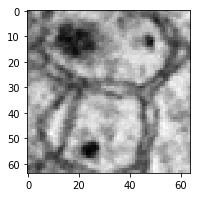


EPOCH:  542
Training loss:....... 0.2013964184080831
Validation loss:..... 0.20192850227393802

EPOCH:  543
Training loss:....... 0.20127084646552515
Validation loss:..... 0.20168660320932902

EPOCH:  544
Training loss:....... 0.20124014516988883
Validation loss:..... 0.20246192505435337

EPOCH:  545
Training loss:....... 0.20104438528275717
Validation loss:..... 0.20193034623350417

EPOCH:  546
Training loss:....... 0.2011753116457607
Validation loss:..... 0.20297558558365655

EPOCH:  547
Training loss:....... 0.20150828966127035
Validation loss:..... 0.2037592844830619

EPOCH:  548
Training loss:....... 0.20078319853867965
Validation loss:..... 0.2023831894473424

EPOCH:  549
Training loss:....... 0.20122163768964835
Validation loss:..... 0.2016264528982223

EPOCH:  550
Training loss:....... 0.20099614808163324
Validation loss:..... 0.20226279232237074

EPOCH:  551
Training loss:....... 0.20151878798160308
Validation loss:..... 0.2018859303659863

EPOCH:  552
Training loss:....... 0

<Figure size 432x288 with 0 Axes>

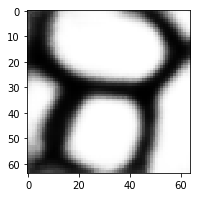

<Figure size 432x288 with 0 Axes>

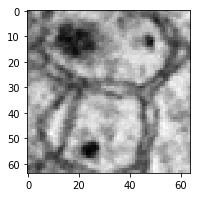


EPOCH:  562
Training loss:....... 0.2013812793519931
Validation loss:..... 0.20176632276603154

EPOCH:  563
Training loss:....... 0.20127497851467743
Validation loss:..... 0.20340552855105626

EPOCH:  564
Training loss:....... 0.20093447317521032
Validation loss:..... 0.20205512122502403

EPOCH:  565
Training loss:....... 0.2011790286999541
Validation loss:..... 0.20218660670613486

EPOCH:  566
Training loss:....... 0.2008411531535962
Validation loss:..... 0.2022966638443962

EPOCH:  567
Training loss:....... 0.20077488288140524
Validation loss:..... 0.2008369548453225

EPOCH:  568
Training loss:....... 0.200937697062858
Validation loss:..... 0.20216370196569533

EPOCH:  569
Training loss:....... 0.20103604534563546
Validation loss:..... 0.2024632008775832

EPOCH:  570
Training loss:....... 0.20102831402335303
Validation loss:..... 0.2011605023391663

EPOCH:  571
Training loss:....... 0.2010659244589912
Validation loss:..... 0.20403143385099987

EPOCH:  572
Training loss:....... 0.201

<Figure size 432x288 with 0 Axes>

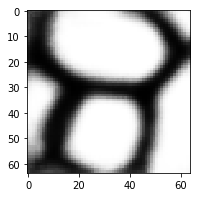

<Figure size 432x288 with 0 Axes>

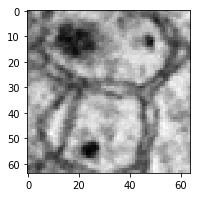


EPOCH:  582
Training loss:....... 0.2010502564830902
Validation loss:..... 0.20142237652861883

EPOCH:  583
Training loss:....... 0.2008732492074418
Validation loss:..... 0.20254361605833446

EPOCH:  584
Training loss:....... 0.20089403985026547
Validation loss:..... 0.2020314946061089

EPOCH:  585
Training loss:....... 0.20094711288286093
Validation loss:..... 0.20225833096201457

EPOCH:  586
Training loss:....... 0.20094826603278565
Validation loss:..... 0.20024996049820432
NEW BEST Loss: 0.20024996049820432 ........old best:0.20041272469929286


EPOCH:  587
Training loss:....... 0.20126529271229388
Validation loss:..... 0.20165941686857314

EPOCH:  588
Training loss:....... 0.20109032746701958
Validation loss:..... 0.20162908354448894

EPOCH:  589
Training loss:....... 0.20138582339682898
Validation loss:..... 0.201474653113456

EPOCH:  590
Training loss:....... 0.20111038952399365
Validation loss:..... 0.20103520036689818

EPOCH:  591
Training loss:....... 0.20097707111995441
Vali

In [17]:
save_bst = 'experiments/unet_res//temp_best.pth'
save_last = 'experiments/unet_res/temp_600.pth'
hist = train_loop(train_loader,val_loader, model,optimizer,scheduler,criterion,
                 save_bst,save_last, epochs, loop_img)